In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import ttest_ind, f_oneway
from scipy.stats import mannwhitneyu
from scipy import stats
import pingouin as pg
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score


# Encodig

In [28]:
df = pd.read_csv('Students_Grading_Dataset.csv')

df_encoded = pd.DataFrame()

df_encoded['Codified_Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

df_encoded['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())

df_encoded['Department'] = df['Department']

department_dummies = pd.get_dummies(df['Department'], prefix='Department', drop_first=True)
department_dummies = department_dummies.astype(int)
df_encoded = pd.concat([df_encoded, department_dummies], axis=1)


df_encoded['Attendance'] = df['Attendance (%)'] / 100

df_encoded['Midterm_Score'] = df['Midterm_Score'] / 100
df_encoded['Final_Score'] = df['Final_Score'] / 100
df_encoded['Assignments_Avg'] = df['Assignments_Avg'] / 100
df_encoded['Quizzes_Avg'] = df['Quizzes_Avg'] / 100
df_encoded['Participation_Score'] = df['Participation_Score'] / 100
df_encoded['Projects_Score'] = df['Projects_Score'] / 100
df_encoded['Total_Score'] = df['Total_Score'] / 100

grade_mapping_normalized = {'A': 1, 'B': 0.75, 'C': 0.5, 'D': 0.25, 'F': 0}
df_encoded['Normalized_Grade'] = df['Grade'].map(grade_mapping_normalized)

df_encoded['Normalized_Study_Hours_per_Week'] = (df['Study_Hours_per_Week'] - df['Study_Hours_per_Week'].min()) / (df['Study_Hours_per_Week'].max() - df['Study_Hours_per_Week'].min())

yes_no_mapping = {'Yes': 1, 'No': 0}
df_encoded['Extracurricular_Activities'] = df['Extracurricular_Activities'].map(yes_no_mapping)

df_encoded['Internet_Access_at_Home'] = df['Internet_Access_at_Home'].map(yes_no_mapping)

education_mapping = {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}
df_encoded['Parent_Education_Level'] = df['Parent_Education_Level'].map(education_mapping)
scaler = MinMaxScaler()
df_encoded['Parent_Education_Level'] = scaler.fit_transform(df_encoded[['Parent_Education_Level']])

family_income_level_mapping = {'Low': 0, 'Medium': 0.5, 'High': 1}
df_encoded['Normalized_Family_Income_Level'] = df['Family_Income_Level'].map(family_income_level_mapping)

df_encoded['Stress_Level (1-10)'] = scaler.fit_transform(df[['Stress_Level (1-10)']])

df_encoded['Normalized_Sleep_Hours_per_Night'] = (df['Sleep_Hours_per_Night'] - df['Sleep_Hours_per_Night'].min()) / (df['Sleep_Hours_per_Night'].max() - df['Sleep_Hours_per_Night'].min())


df_encoded.head()

,Codified_Gender,Age,Department,Department_CS,Department_Engineering,Department_Mathematics,Attendance,Midterm_Score,Final_Score,Assignments_Avg,...,Projects_Score,Total_Score,Normalized_Grade,Normalized_Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Normalized_Family_Income_Level,Stress_Level (1-10),Normalized_Sleep_Hours_per_Night
0,0,0.666667,Mathematics,0,0,1,0.9736,0.4061,0.5961,0.7369,...,0.6284,0.8349,0.5,0.212,1,0,0.666667,0.5,0.000000,0.38
1,1,0.000000,Business,0,0,0,0.9771,0.5727,0.7400,0.7423,...,0.9823,0.9229,0.0,0.884,0,0,0.000000,0.0,0.333333,0.06
2,1,1.000000,Engineering,0,1,0,0.9952,0.4184,0.6385,0.8585,...,0.9122,0.9355,0.0,0.296,1,0,0.000000,0.0,0.888889,0.42
3,0,1.000000,Engineering,0,1,0,0.9038,0.4565,0.4444,0.6810,...,0.5548,0.5103,1.0,0.820,0,1,0.000000,0.0,0.777778,0.18
4,0,0.833333,CS,1,0,0,0.5941,0.5313,0.6177,0.6766,...,0.8743,0.9091,1.0,0.332,1,0,0.666667,0.5,0.555556,0.10


# EDA + Imputación

A continuación se lleva a cabo un análisis exploratorio, junto con la imputación de datos faltantes. Primero, se analiza la matriz de correlación, para evaluar rápidamente posibles relaciones entre variables.

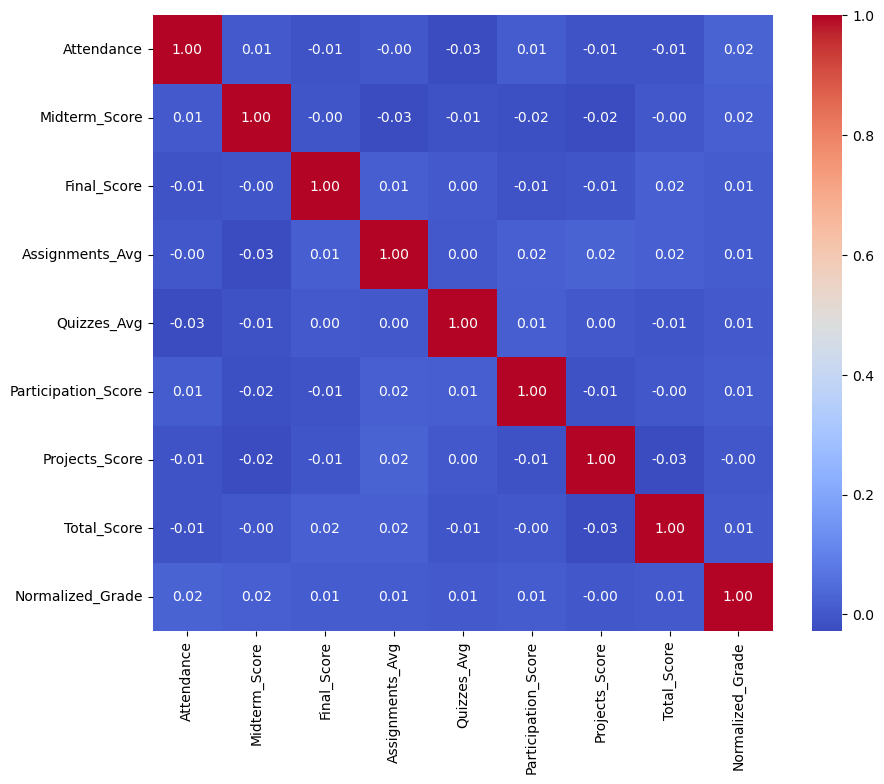

In [30]:
# Calcular la matriz de correlación
correlation_matrix = df_encoded[['Attendance', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 
                         'Quizzes_Avg', 'Participation_Score', 'Projects_Score', 'Total_Score', 'Normalized_Grade']].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

No se aprecia gran correlación entre las variables seleccionadas.

# Análisis de datos faltantes en `Parent_Education_Level`

Separo el dataset en dos grupos, con y sin datos faltantes, y analizo si hay algún tipo de relación entre los grupos y las diferentes variables.

In [31]:
has_nan = df_encoded[df_encoded['Parent_Education_Level'].isna()]
no_nan = df_encoded[df_encoded['Parent_Education_Level'].notna()]

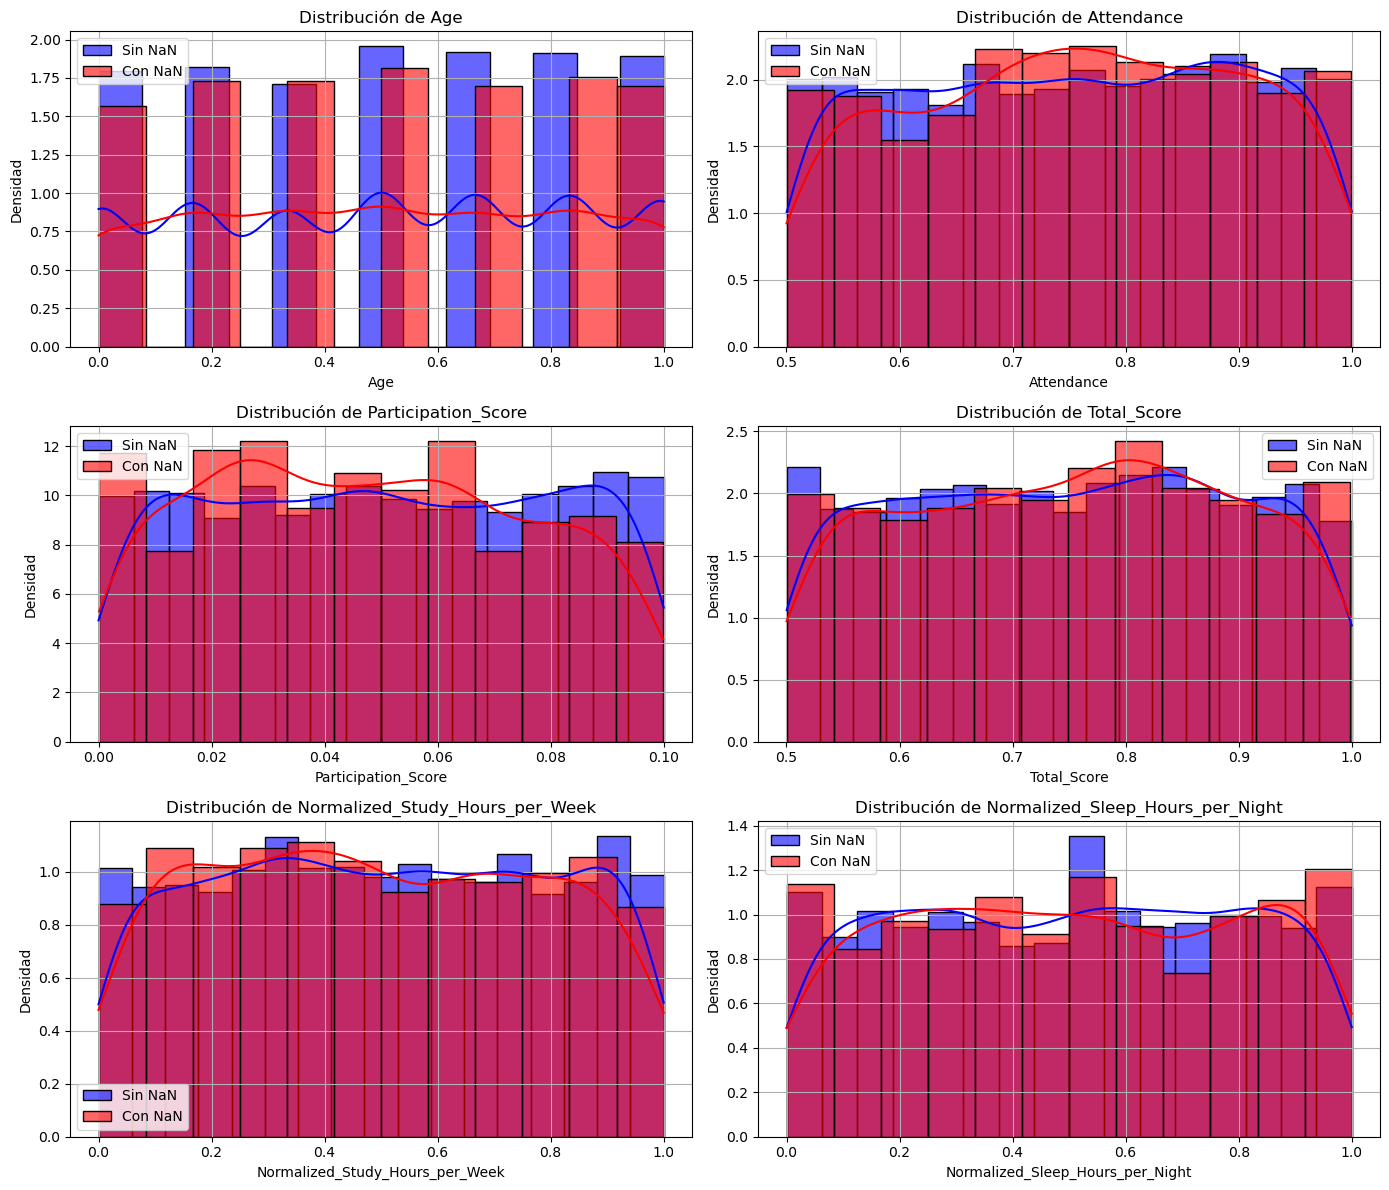

In [32]:
# Lista de variables
variables = [
    'Age',
    'Attendance',
    'Participation_Score',
    'Total_Score',
    'Normalized_Study_Hours_per_Week',
    'Normalized_Sleep_Hours_per_Night'
]

# Set up plot
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()  # Para iterar fácil

# Graficar cada variable para los dos grupos
for i, var in enumerate(variables):
    sns.histplot(no_nan[var], kde=True, ax=axes[i], color='blue', label='Sin NaN', stat='density', alpha=0.6)
    sns.histplot(has_nan[var], kde=True, ax=axes[i], color='red', label='Con NaN', stat='density', alpha=0.6)
    
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Densidad')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Realizo un test de Mann-Whitney U para todas las variables, comparando los grupos con y sin datos faltantes. De esta manera, evalúo si los datos son o no son MCAR.

In [33]:
# Lista de variables a comparar
variables = [
    'Codified_Gender', 'Age', 'Department_CS', 'Department_Engineering',
    'Department_Mathematics', 'Attendance', 'Midterm_Score', 'Final_Score', 
    'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score', 'Projects_Score',
    'Total_Score', 'Normalized_Grade', 'Normalized_Study_Hours_per_Week',
    'Extracurricular_Activities', 'Internet_Access_at_Home','Normalized_Family_Income_Level',
    'Stress_Level (1-10)', 'Normalized_Sleep_Hours_per_Night'
]

not_mcar_variables = []

# Realizar la prueba de Mann-Whitney U para cada variable
for var in variables:
    if var in has_nan and var in no_nan:  # Asegurarse de que la columna existe en ambos grupos
        stat, p_value = mannwhitneyu(has_nan[var], no_nan[var], alternative='two-sided')
        
        # Si el valor p es menor que 0.05, no es MCAR
        if p_value < 0.05:
            not_mcar_variables.append(var)  # Guardar la variable en la lista

# Mostrar las variables que NO son MCAR
print("Variables que NO son MCAR:")
print(not_mcar_variables)

Variables que NO son MCAR:
['Participation_Score']


Para entender la naturaleza de los datos faltantes en la variable `Parent_Education_Level`, se realizó un análisis exploratorio para evaluar si estos datos pueden considerarse:

- **MCAR** (Missing Completely At Random)
- **MAR** (Missing At Random)
- **MNAR** (Missing Not At Random)

### Prueba de MCAR

Se utilizó la prueba de Mann-Whitney U para comparar la distribución de distintas variables numéricas entre dos grupos:

- Estudiantes con valores faltantes en `Parent_Education_Level`.
- Estudiantes con datos no faltantes en esa misma variable.

Se encontró que la única variable cuya distribución es significativamente distinta entre ambos grupos es `Participation_Score`, mientras que el resto de las variables no muestran diferencias estadísticamente significativas. Esto indica que los datos **no son MCAR**, ya que la falta de datos parece depender de al menos una variable observada.

### Evaluación de MNAR

No se encontraron indicios ni se dispone de evidencia para asumir que la probabilidad de que falten datos depende directamente de los valores faltantes de `Parent_Education_Level`. Es decir, no hay argumentos para suponer que el valor faltante depende del propio valor que falta (lo cual caracterizaría un mecanismo MNAR).

### Conclusión: Datos MAR

Dado que:
- Se ha descartado el mecanismo MCAR (los datos faltantes no son completamente aleatorios),
- Y no hay evidencia que respalde un mecanismo MNAR,

Se concluye que los datos faltantes en `Parent_Education_Level` son **MAR** (Missing At Random), ya que su ausencia depende de variables observadas (como `Participation_Score`) pero no de la propia variable faltante.

### Imputación con MICE

Dado que el mecanismo es MAR, se opta por utilizar el método **MICE (Multiple Imputation by Chained Equations)** para imputar los valores faltantes. Este método es apropiado porque modela la variable con datos faltantes utilizando otras variables predictoras del dataset, respetando el supuesto MAR.



In [34]:
# Crear un nuevo DataFrame con las variables seleccionadas para la imputación
variables_para_imputar = [
    'Parent_Education_Level',
    'Participation_Score',
    'Normalized_Family_Income_Level',
    'Normalized_Study_Hours_per_Week',
    'Total_Score',
    'Codified_Gender',
    'Age',
    'Attendance'
]

# Crear una copia del dataset con solo las columnas necesarias
df_impute = df_encoded[variables_para_imputar].copy()

# Aplicar imputación con IterativeImputer
imputer = IterativeImputer(random_state=0)
df_imputed_array = imputer.fit_transform(df_impute)

# Convertir el resultado a DataFrame y restaurar los nombres de columna
df_imputed = pd.DataFrame(df_imputed_array, columns=variables_para_imputar)

# Reemplazar la columna imputada en el dataset original
df_encoded['Parent_Education_Level'] = df_imputed['Parent_Education_Level']

df_encoded.head()

,Codified_Gender,Age,Department,Department_CS,Department_Engineering,Department_Mathematics,Attendance,Midterm_Score,Final_Score,Assignments_Avg,...,Projects_Score,Total_Score,Normalized_Grade,Normalized_Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Normalized_Family_Income_Level,Stress_Level (1-10),Normalized_Sleep_Hours_per_Night
0,0,0.666667,Mathematics,0,0,1,0.9736,0.4061,0.5961,0.7369,...,0.6284,0.8349,0.5,0.212,1,0,0.666667,0.5,0.000000,0.38
1,1,0.000000,Business,0,0,0,0.9771,0.5727,0.7400,0.7423,...,0.9823,0.9229,0.0,0.884,0,0,0.000000,0.0,0.333333,0.06
2,1,1.000000,Engineering,0,1,0,0.9952,0.4184,0.6385,0.8585,...,0.9122,0.9355,0.0,0.296,1,0,0.000000,0.0,0.888889,0.42
3,0,1.000000,Engineering,0,1,0,0.9038,0.4565,0.4444,0.6810,...,0.5548,0.5103,1.0,0.820,0,1,0.000000,0.0,0.777778,0.18
4,0,0.833333,CS,1,0,0,0.5941,0.5313,0.6177,0.6766,...,0.8743,0.9091,1.0,0.332,1,0,0.666667,0.5,0.555556,0.10


In [35]:
df_encoded.isna().sum()

Codified_Gender                     0
Age                                 0
Department                          0
Department_CS                       0
Department_Engineering              0
Department_Mathematics              0
Attendance                          0
Midterm_Score                       0
Final_Score                         0
Assignments_Avg                     0
Quizzes_Avg                         0
Participation_Score                 0
Projects_Score                      0
Total_Score                         0
Normalized_Grade                    0
Normalized_Study_Hours_per_Week     0
Extracurricular_Activities          0
Internet_Access_at_Home             0
Parent_Education_Level              0
Normalized_Family_Income_Level      0
Stress_Level (1-10)                 0
Normalized_Sleep_Hours_per_Night    0
dtype: int64

## Análisis entre grupos

Se analiza si existe alguna relación entre la nota obtenida por los alumnos (`Total_Score`) y tres factores: su **género**, el **departamento** al que pertenecen, y su **asistencia** a clase. 

Para el análisis de asistencia, se clasifica en dos grupos:
- **Alta asistencia**: cuando el porcentaje de asistencia es mayor al 85%.
- **Baja asistencia**: cuando la asistencia es menor o igual al 85%.

El análisis se realiza en dos etapas:

1. **Evaluación de la normalidad**:  
   Se verifica si la distribución de `Total_Score` en cada grupo (por ejemplo, hombres vs. mujeres, o estudiantes de distintos departamentos) sigue una distribución normal. Para ello se utiliza la prueba de **Shapiro-Wilk**.

2. **Pruebas de hipótesis**:  
   En base a los resultados del test de normalidad, se decide si aplicar pruebas **paramétricas** o **no paramétricas** para comparar los grupos. En caso de que las distribuciones no sean normales, se emplean pruebas no paramétricas como **Mann-Whitney U** o **Kruskal-Wallis**, según corresponda.

Este análisis permite determinar si las diferencias observadas en las notas entre los distintos grupos son estadísticamente significativas.



Grupo: 0 (Género)


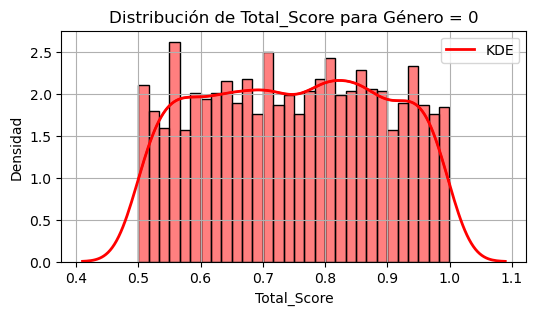

Shapiro-Wilk: W = 0.9582, p = 0.0000
La distribución NO parece normal (p < 0.05)


Grupo: 1 (Género)


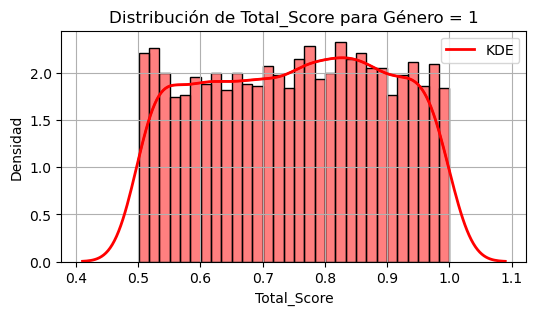

Shapiro-Wilk: W = 0.9562, p = 0.0000
La distribución NO parece normal (p < 0.05)


Grupo: Mathematics (Departamento)


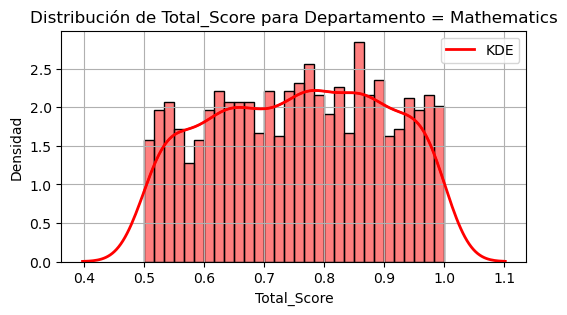

Shapiro-Wilk: W = 0.9603, p = 0.0000
La distribución NO parece normal (p < 0.05)


Grupo: Business (Departamento)


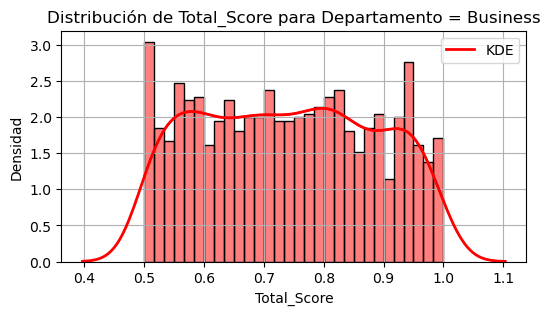

Shapiro-Wilk: W = 0.9565, p = 0.0000
La distribución NO parece normal (p < 0.05)


Grupo: Engineering (Departamento)


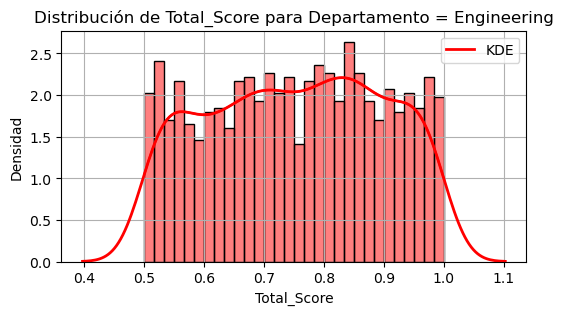

Shapiro-Wilk: W = 0.9574, p = 0.0000
La distribución NO parece normal (p < 0.05)


Grupo: CS (Departamento)


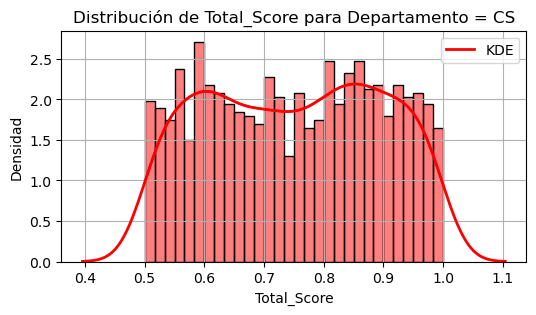

Shapiro-Wilk: W = 0.9531, p = 0.0000
La distribución NO parece normal (p < 0.05)


Grupo: High (Asistencia (>0.85))


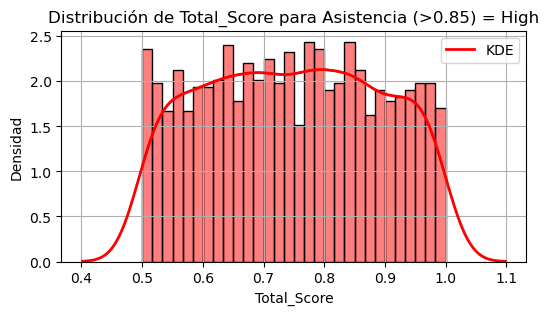

Shapiro-Wilk: W = 0.9599, p = 0.0000
La distribución NO parece normal (p < 0.05)


Grupo: Low (Asistencia (≤0.85))


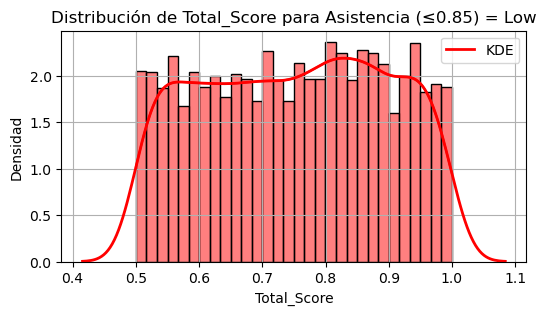

Shapiro-Wilk: W = 0.9559, p = 0.0000
La distribución NO parece normal (p < 0.05)



In [36]:
def check_score_normality_by_group(df, score_column, gender_column, department_column, attendance_column):
    def run_normality_test(group_data, group_name, by):
        print(f"\nGrupo: {group_name} ({by})")
        plt.figure(figsize=(6, 3))
        sns.histplot(group_data, kde=True, stat="density", bins=30, color='red', edgecolor='black')
        sns.kdeplot(group_data, color='red', linewidth=2, label='KDE')
        plt.title(f'Distribución de {score_column} para {by} = {group_name}')
        plt.xlabel(score_column)
        plt.ylabel('Densidad')
        plt.grid(True)
        plt.legend()
        plt.show()

        if len(group_data) < 3:
            print("Muy pocos datos para hacer el test de Shapiro.\n")
            return
        
        shapiro = stats.shapiro(group_data)
        print(f"Shapiro-Wilk: W = {shapiro.statistic:.4f}, p = {shapiro.pvalue:.4f}")
        if shapiro.pvalue < 0.05:
            print("La distribución NO parece normal (p < 0.05)\n")
        else:
            print("La distribución podría ser normal (p ≥ 0.05)\n")

    # Por género
    for gender in df[gender_column].dropna().unique():
        group_data = df[df[gender_column] == gender][score_column].dropna()
        run_normality_test(group_data, gender, "Género")

    # Por departamento
    for dept in df[department_column].dropna().unique():
        group_data = df[df[department_column] == dept][score_column].dropna()
        run_normality_test(group_data, dept, "Departamento")

    # Por asistencia (High > 0.85, Low ≤ 0.85)
    high_att = df[df[attendance_column] > 0.85][score_column].dropna()
    low_att = df[df[attendance_column] <= 0.85][score_column].dropna()
    
    run_normality_test(high_att, "High", "Asistencia (>0.85)")
    run_normality_test(low_att, "Low", "Asistencia (≤0.85)")

check_score_normality_by_group(
    df_encoded,
    score_column='Total_Score',
    gender_column='Codified_Gender',
    department_column='Department',
    attendance_column='Attendance'
)



No hay normalidad en ninguno de los grupos, por lo tanto se procede a realizar análisis no paramétricos.

In [37]:
def simplified_non_parametric_analysis(df, score_column, gender_column, department_column, attendance_column):
    # Género (Mann-Whitney U Test)
    male_scores = df[df[gender_column] == 1][score_column].dropna()
    female_scores = df[df[gender_column] == 0][score_column].dropna()

    gender_test = stats.mannwhitneyu(male_scores, female_scores, alternative='two-sided')
    print("Mann-Whitney U para Género:")
    print(f"U = {gender_test.statistic:.4f}, p = {gender_test.pvalue:.4f}")

    # Departamentos (Kruskal-Wallis H Test)
    departments = df[department_column].unique()
    department_scores = [df[df[department_column] == dep][score_column].dropna() for dep in departments]

    dept_test = stats.kruskal(*department_scores)
    print("\nKruskal-Wallis entre Departamentos:")
    print(f"H = {dept_test.statistic:.4f}, p = {dept_test.pvalue:.4f}")

    # Asistencia (Mann-Whitney U Test con umbral 0.85)
    high_att = df[df[attendance_column] > 0.85][score_column].dropna()
    low_att = df[df[attendance_column] <= 0.85][score_column].dropna()

    attendance_test = stats.mannwhitneyu(high_att, low_att, alternative='two-sided')
    print("\nMann-Whitney U para Asistencia:")
    print(f"U = {attendance_test.statistic:.4f}, p = {attendance_test.pvalue:.4f}")

simplified_non_parametric_analysis(
    df_encoded,
    score_column='Total_Score',
    gender_column='Codified_Gender',
    department_column='Department',
    attendance_column='Attendance'
)



Mann-Whitney U para Género:
U = 3143973.5000, p = 0.6911

Kruskal-Wallis entre Departamentos:
H = 9.8480, p = 0.0199

Mann-Whitney U para Asistencia:
U = 2625459.5000, p = 0.2970


No hay evidencia suficiente de que las muestras provengan de poblaciones diferentes, por lo tanto se concluye que no hay relación significativa entre el `Total_Score` y el género, el departamento o el porcentaje de asistencia (mayor o menor al 85%).

In [38]:
"""# 4. Modelado Predictivo
def predictive_modeling(df):
    # Preparación de datos
    X = df[['Quiz1', 'Quiz2', 'Midterm', 'Study_Hours', 'Attendance_Rate']]
    y = df['Final_Grade']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Insight 5: Importancia de características
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    plt.figure(figsize=(10,6))
    pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
    plt.title('Importancia de Características (Random Forest)')
    plt.show()
    
    # Insight 8: Comparación de modelos
    models = {
        'Random Forest': rf,
        'KNN': KNeighborsClassifier(n_neighbors=15),
        'SVM': SVC(kernel='rbf')
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        results[name] = accuracy
    
    print("\nComparación de Modelos:")
    print(pd.Series(results).sort_values(ascending=False))

predictive_modeling(df)"""

'# 4. Modelado Predictivo\ndef predictive_modeling(df):\n    # Preparación de datos\n    X = df[[\'Quiz1\', \'Quiz2\', \'Midterm\', \'Study_Hours\', \'Attendance_Rate\']]\n    y = df[\'Final_Grade\']\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n    \n    # Insight 5: Importancia de características\n    rf = RandomForestClassifier(n_estimators=100)\n    rf.fit(X_train, y_train)\n    \n    plt.figure(figsize=(10,6))\n    pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind=\'barh\')\n    plt.title(\'Importancia de Características (Random Forest)\')\n    plt.show()\n    \n    # Insight 8: Comparación de modelos\n    models = {\n        \'Random Forest\': rf,\n        \'KNN\': KNeighborsClassifier(n_neighbors=15),\n        \'SVM\': SVC(kernel=\'rbf\')\n    }\n    \n    results = {}\n    for name, model in models.items():\n        model.fit(X_train, y_train)\n        pred = model.predict(X_test)\n        accuracy = ac

In [39]:
"""# 5. Segmentación con Clustering
def student_clustering(df):
    # Insight 9: Segmentación de estudiantes
    features = ['Total_Score', 'Study_Hours', 'Attendance_Rate']
    X = df[features]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determinación óptima de clusters
    silhouette_scores = []
    for k in range(2, 5):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        silhouette_scores.append(silhouette_score(X_scaled, labels))
    
    optimal_k = np.argmax(silhouette_scores) + 2
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)
    
    # Visualización 3D
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_scaled[:,0], X_scaled[:,1], X_scaled[:,2], 
                        c=df['Cluster'], cmap='viridis')
    plt.title('Segmentación de Estudiantes')
    ax.set_xlabel('Puntaje Total')
    ax.set_ylabel('Horas Estudio')
    ax.set_zlabel('Asistencia')
    plt.show()

student_clustering(df)"""

"# 5. Segmentación con Clustering\ndef student_clustering(df):\n    # Insight 9: Segmentación de estudiantes\n    features = ['Total_Score', 'Study_Hours', 'Attendance_Rate']\n    X = df[features]\n    \n    scaler = StandardScaler()\n    X_scaled = scaler.fit_transform(X)\n    \n    # Determinación óptima de clusters\n    silhouette_scores = []\n    for k in range(2, 5):\n        kmeans = KMeans(n_clusters=k, random_state=42)\n        labels = kmeans.fit_predict(X_scaled)\n        silhouette_scores.append(silhouette_score(X_scaled, labels))\n    \n    optimal_k = np.argmax(silhouette_scores) + 2\n    kmeans = KMeans(n_clusters=optimal_k, random_state=42)\n    df['Cluster'] = kmeans.fit_predict(X_scaled)\n    \n    # Visualización 3D\n    fig = plt.figure(figsize=(12,8))\n    ax = fig.add_subplot(111, projection='3d')\n    scatter = ax.scatter(X_scaled[:,0], X_scaled[:,1], X_scaled[:,2], \n                        c=df['Cluster'], cmap='viridis')\n    plt.title('Segmentación de Estudian

In [40]:
"""# 6. Optimización de Hiperparámetros
def hyperparameter_tuning(X_train, y_train):
    # Insight 10: Optimización de KNN
    pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier()
    )
    
    param_grid = {
        'kneighborsclassifier__n_neighbors': range(1, 30),
        'kneighborsclassifier__weights': ['uniform', 'distance']
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    print("\nMejores parámetros KNN:")
    print(grid_search.best_params_)
    
    plt.figure(figsize=(10,6))
    results = pd.DataFrame(grid_search.cv_results_)
    plt.plot(results['param_kneighborsclassifier__n_neighbors'], 
             results['mean_test_score'])
    plt.title('Optimización de Hiperparámetros KNN')
    plt.xlabel('Número de Vecinos (k)')
    plt.ylabel('Precisión')
    plt.show()

hyperparameter_tuning(X_train, y_train)"""

'# 6. Optimización de Hiperparámetros\ndef hyperparameter_tuning(X_train, y_train):\n    # Insight 10: Optimización de KNN\n    pipeline = make_pipeline(\n        StandardScaler(),\n        KNeighborsClassifier()\n    )\n    \n    param_grid = {\n        \'kneighborsclassifier__n_neighbors\': range(1, 30),\n        \'kneighborsclassifier__weights\': [\'uniform\', \'distance\']\n    }\n    \n    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=\'accuracy\')\n    grid_search.fit(X_train, y_train)\n    \n    print("\nMejores parámetros KNN:")\n    print(grid_search.best_params_)\n    \n    plt.figure(figsize=(10,6))\n    results = pd.DataFrame(grid_search.cv_results_)\n    plt.plot(results[\'param_kneighborsclassifier__n_neighbors\'], \n             results[\'mean_test_score\'])\n    plt.title(\'Optimización de Hiperparámetros KNN\')\n    plt.xlabel(\'Número de Vecinos (k)\')\n    plt.ylabel(\'Precisión\')\n    plt.show()\n\nhyperparameter_tuning(X_train, y_train)'